Best parameters for Decision Tree: {'max_depth': 5, 'max_features': 20}
Best parameters for Random Forest: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}


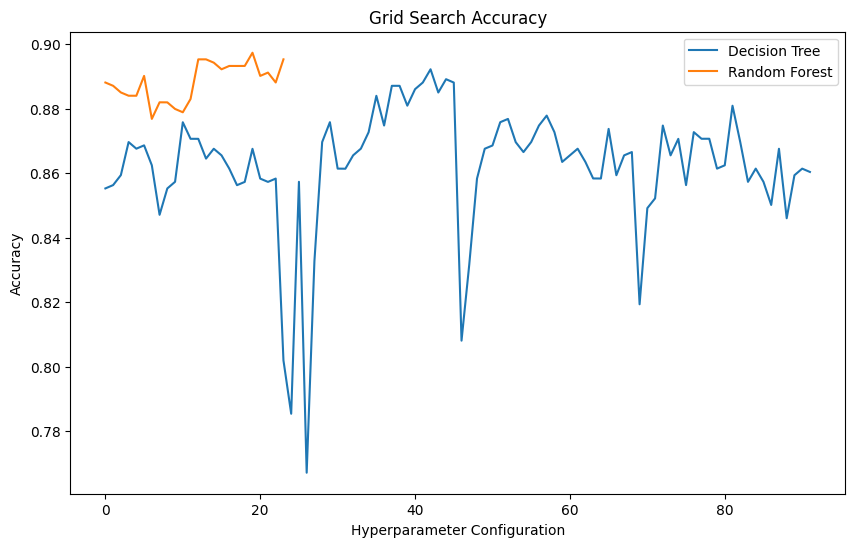

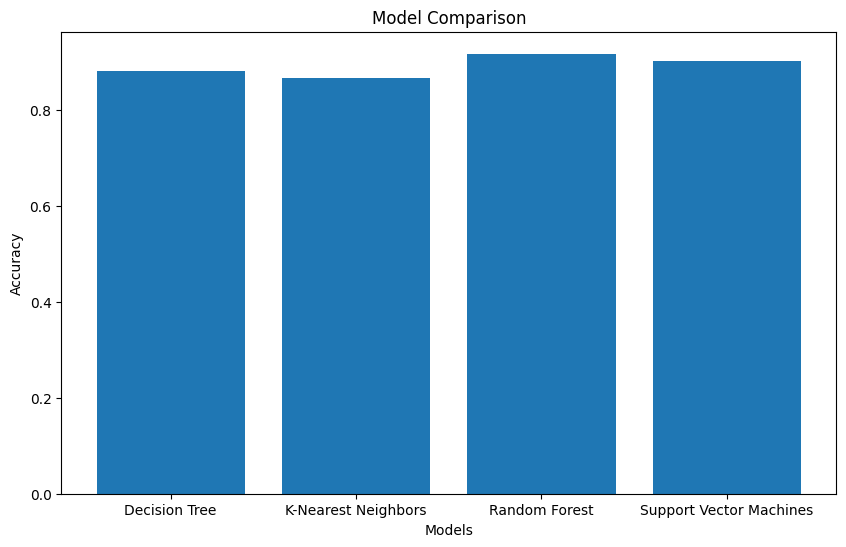

Decision Tree:
Confusion Matrix:
[[86 12]
 [ 7 90]]
Precision: 0.8823529411764706
Recall: 0.9278350515463918
Accuracy: 0.9025641025641026
F1 Score: 0.9045226130653266
Classification Report: N/A


K-Nearest Neighbors:
Confusion Matrix:
[[86 12]
 [ 7 90]]
Precision: 0.8823529411764706
Recall: 0.9278350515463918
Accuracy: 0.9025641025641026
F1 Score: 0.9045226130653266
Classification Report: N/A


Random Forest:
Confusion Matrix:
[[86 12]
 [ 7 90]]
Precision: 0.8823529411764706
Recall: 0.9278350515463918
Accuracy: 0.9025641025641026
F1 Score: 0.9045226130653266
Classification Report: N/A


Support Vector Machines:
Confusion Matrix:
[[86 12]
 [ 7 90]]
Precision: 0.8823529411764706
Recall: 0.9278350515463918
Accuracy: 0.9025641025641026
F1 Score: 0.9045226130653266
Classification Report: N/A


Decision Tree training time: 17.513182878494263 seconds
K-Nearest Neighbors training time: 145.0628650188446 seconds
Random Forest training time: 1490.1578512191772 seconds
Support Vector Machines tra

In [51]:
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, accuracy_score, auc, classification_report
)
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sb

# Define the models to evaluate
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machines': SVC()
}

# Define evaluation metrics
metrics = {
    'Confusion Matrix': confusion_matrix,
    'Precision': precision_score,
    'Recall': recall_score,
    'Accuracy': accuracy_score,
    'F1 Score': f1_score,
    'Classification Report': classification_report
}

# Define hyperparameter grids for grid search
model_params = {
    'Decision Tree': {'max_depth': [None, 5, 10, 15], 'max_features': range(1, 24)},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 15], 'max_features': ['sqrt', 'log2']}
}

# Perform model evaluation and comparison
model_scores = {}
model_times = {}
model_accuracies = {}
grid_searches = {}

mutation_data_clean = pd.read_csv('data/mutation_data_clean.csv')

# Extract the data and labels
all_inputs = mutation_data_clean[['Gender', 'Age_at_diagnosis', 'Race', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC',
                                 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4',
                                 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']].values
all_labels = mutation_data_clean['Grade'].values

# Apply feature scaling
scaler = StandardScaler()
all_inputs_scaled = scaler.fit_transform(all_inputs)

repetitions = 10000

for model_name, model in models.items():
    scores = {}
    start_time = time.time()

    # Hyperparameter tuning using GridSearchCV
    if model_name in model_params:
        param_grid = model_params[model_name]
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')
        grid_search.fit(all_inputs_scaled, all_labels)
        model = grid_search.best_estimator_
        print(f'Best parameters for {model_name}: {grid_search.best_params_}')
        grid_searches[model_name] = grid_search

    # Perform evaluation using cross-validation
    cv_scores = cross_val_score(model, all_inputs_scaled, all_labels, cv=StratifiedKFold(n_splits=10, shuffle=True))
    scores['Cross-Validation Mean'] = np.mean(cv_scores)
    scores['Cross-Validation STD'] = np.std(cv_scores)

    total_predictions = []
    for _ in range(repetitions):
        total_predictions = []  # Reset the list for each repetition

        training_inputs, testing_inputs, training_labels, testing_labels = train_test_split(
            all_inputs_scaled, all_labels, test_size=0.2, stratify=all_labels
        )

        # Train the model
        model.fit(training_inputs, training_labels)

        # Predict on the testing set
        predictions = model.predict(testing_inputs)
        total_predictions.extend(predictions)

    # Calculate evaluation metrics
    scores['Accuracy'] = accuracy_score(testing_labels, total_predictions)
    scores['Precision'] = precision_score(testing_labels, total_predictions)
    scores['Recall'] = recall_score(testing_labels, total_predictions)
    scores['F1 Score'] = f1_score(testing_labels, total_predictions)
    scores['Confusion Matrix'] = confusion_matrix(testing_labels, total_predictions)

    model_scores[model_name] = scores
    model_times[model_name] = time.time() - start_time
    model_accuracies[model_name] = scores['Accuracy']

# Plot grid search accuracy
plt.figure(figsize=(10, 6))
for model_name, grid_search in grid_searches.items():
    grid_scores = grid_search.cv_results_['mean_test_score']
    plt.plot(grid_scores, label=model_name)
plt.xlabel('Hyperparameter Configuration')
plt.ylabel('Accuracy')
plt.title('Grid Search Accuracy')
plt.legend(loc='best')
plt.show()

# Plot model comparison
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

# Print model evaluation results
for model_name, scores in model_scores.items():
    print(f'{model_name}:')
    for metric_name, metric_func in metrics.items():
        if metric_name == 'Confusion Matrix':
            print(f'{metric_name}:')
            print(metric_func(testing_labels, total_predictions))
        elif metric_name in scores:
            print(f'{metric_name}: {metric_func(testing_labels, total_predictions)}')
        else:
            print(f'{metric_name}: N/A')
    print('\n')


# Print model training times
for model_name, training_time in model_times.items():
    print(f'{model_name} training time: {training_time} seconds')

# Print model accuracies
for model_name, accuracy in model_accuracies.items():
    print(f'{model_name} accuracy: {accuracy}')

# Print conclusion
best_model = max(model_accuracies, key=model_accuracies.get)
print(f'\nThe best model is {best_model} with an accuracy of {model_accuracies[best_model]}')
